# Solve Navier-Stokes equation with fully implicit Crank-Nicolson timestepping

In [1]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, vis, compile, operators

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyiga.vform import VForm, inner, grad, div, dx

def vlaplace_vf(dim):
    vf = VForm(dim, vec=dim**2)
    u, v = vf.basisfuns(components=(dim, dim))
    vf.add(inner(grad(u), grad(v)) * dx)
    return vf

def div_vf(dim):
    vf = VForm(dim, vec=dim)
    u, p = vf.basisfuns(components=(dim, 1), spaces=(0,1))
    vf.add(div(u) * p * dx)
    return vf

def nlconv_vf(dim):
    """Nonlinear convection term"""
    vf = VForm(dim, vec=dim, arity=1)
    u = vf.input('vel', shape=(dim,), updatable=True)
    v = vf.basisfuns(components=(dim,))
    Gu = vf.JacInv.T.dot(grad(u).T).T
    vf.add(Gu.dot(u).dot(v) * dx)
    return vf

def linconv_vf(dim):
    """Linearized convection term (freeze velocity, but not its gradient)"""
    vf = VForm(dim, vec=dim**2)
    u0 = vf.input('vel', shape=(dim,), updatable=True)
    u, v = vf.basisfuns(components=(dim, dim))
    Gu = grad(u)
    vf.add(Gu.dot(u0).dot(v) * dx)
    return vf

Asm_vlaplace, Asm_div, Asm_nlconv, Asm_linconv = compile.compile_vforms(
    (vlaplace_vf(2), div_vf(2), nlconv_vf(2), linconv_vf(2))
)

Compiling /home/hilbert/chofreither/.cache/pyiga/modules/mod777d666abd4a249e.pyx because it changed.
[1/1] Cythonizing /home/hilbert/chofreither/.cache/pyiga/modules/mod777d666abd4a249e.pyx


In [3]:
# define geometry
geo = geometry.unit_square()
geo.coeffs[...,  0] *= 3

# define isogeometric discretization space (Taylor-Hood like)
p = 2     # spline degree of velocity space
n_el = (32, 96)   # number of elements in y/x direction

kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=1) for n in n_el)
kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)

m_u = tuple(kv.numdofs for kv in kvs_u)
m_p = tuple(kv.numdofs for kv in kvs_p)
n_u1 = prod(m_u)
n_u = 2 * n_u1
n_p = prod(m_p)

In [4]:
def get_components(u):
    """Split solution vector into velocity and pressure components."""
    u1 = u[:n_u1].reshape(m_u)
    u2 = u[n_u1:n_u].reshape(m_u)
    U = np.stack((u1,u2), axis=-1)
    prs = u[n_u:].reshape(m_p)
    return U, prs

def vel_norm(u):
    """Return a function for evaluating the norm of the velocity."""
    U, pre = get_components(u)
    vel = geometry.BSplineFunc(kvs_u, U)
    def f(X, Y):
        V = vel.grid_eval((Y,X))
        return norm(V, axis=-1)
    return f

In [5]:
def g_inflow(x, y): return (40*y*(1-y)*exp(10*y)/exp(10), 0.0)
def g_zero(x, y):   return (0.0, 0.0)

dir_conds = [ ((0,0), g_zero), ((0,1), g_zero), ((1,0), g_inflow) ]

bcs = assemble.combine_bcs(
    assemble.compute_dirichlet_bc(kvs_u, geo, bcside, g)
    for (bcside, g) in dir_conds
)

In [6]:
# kinematic viscosity
nu = 1e-4

# time step
tau = 5e-2

In [7]:
A_grad = assemble.assemble_vector(Asm_vlaplace(kvs_u, geo))
A_div = assemble.assemble_vector(Asm_div(kvs_u, kvs_p, geo))

M_pre = assemble.mass(kvs_p, geo)
M_vel = assemble.mass(kvs_u, geo)
M_stokes = scipy.sparse.bmat(
    [[M_vel, None, None  ],
     [None, M_vel, None  ],
     [None, None,  M_pre ]],
    format='csr'
)
M_vel_full = scipy.sparse.bmat(
    [[M_vel, None, None  ],
     [None, M_vel, None  ],
     [None, None, scipy.sparse.csr_matrix((n_p,n_p))]], format='csr')

A_stokes = scipy.sparse.bmat(
    [[nu*A_grad, A_div.T],
     [A_div,     1e-10*M_pre]], format='csr')

A_stokes_euler = tau * A_stokes + M_stokes

In [8]:
# compute initial value from Stokes equation
LS = assemble.RestrictedLinearSystem(A_stokes, 0.0, bcs)
u = LS.complete(scipy.sparse.linalg.spsolve(LS.A, LS.b))
solutions = [u.copy()]

In [9]:
U, prs = get_components(u)
vel = geometry.BSplineFunc(kvs_u, U)

asm_nlconv = Asm_nlconv(kvs_u, geo=geo, vel=vel)
asm_linconv = Asm_linconv(kvs_u, geo=geo, vel=vel)

def apply_nl_conv(vel):
    asm_nlconv.update(vel=vel)
    z = asm_nlconv.assemble_vector()
    return np.concatenate((np.rollaxis(z, -1).ravel(), np.zeros(n_p)))

def linearized_ns(vel):
    asm_linconv.update(vel=vel)
    A_linconv = assemble.assemble_vector(asm_linconv)
    A_lns = scipy.sparse.bmat(
        [[nu*A_grad + A_linconv, A_div.T],
         [A_div,                 1e-10*M_pre]],
        format='csr')
    return A_lns

In [10]:
%%time
# Crank-Nicolson iteration
numsteps = 120

u_old = u

for tt in range(numsteps):
    #print(tt,)
    #u_new = u.copy()
    u_new = 2*u - u_old
    J = None
    print('t=%f: %f' % (tt*tau, norm(u)))

    U, pre = get_components(u)
    vel_old = geometry.BSplineFunc(kvs_u, U)
    rhs = -0.5 * (apply_nl_conv(vel_old) + A_stokes.dot(u))

    while True:
        # inner Newton iteration for nonlinear Crank-Nicolson
        U, pre = get_components(u_new)
        vel_new = geometry.BSplineFunc(kvs_u, U)
        res = LS.restrict(rhs + 1/tau*M_vel_full.dot(u-u_new) - 0.5*(apply_nl_conv(vel_new) + A_stokes.dot(u_new)))
        if norm(res) < 1e-4:
            break

        #if J is None:
        J = LS.restrict_matrix(0.5*linearized_ns(vel_new) + 1/tau*M_vel_full)
        J_inv = operators.make_solver(J)
        u_new += LS.extend(J_inv * res)
    print('  inner res:', norm(res))
    u_old = u
    u = u_new
    
    solutions.append(u.copy())

t=0.000000: 21.290290
  inner res: 4.655549312361915e-05
t=0.050000: 22.074419
  inner res: 3.8557616413631025e-05
t=0.100000: 21.601304
  inner res: 3.8454206405288804e-05
t=0.150000: 22.426148
  inner res: 3.698265830909093e-05
t=0.200000: 21.943258
  inner res: 3.695906352635514e-05
t=0.250000: 22.794732
  inner res: 3.61504644563696e-05
t=0.300000: 22.315226
  inner res: 3.455196300371423e-05
t=0.350000: 23.175264
  inner res: 3.2972658076283864e-05
t=0.400000: 22.709093
  inner res: 3.1972350951427795e-05
t=0.450000: 23.563393
  inner res: 3.15853256804161e-05
t=0.500000: 23.118344
  inner res: 3.119727993087006e-05
t=0.550000: 23.960542
  inner res: 3.0665254007892606e-05
t=0.600000: 23.539482
  inner res: 2.9592873502305176e-05
t=0.650000: 24.365849
  inner res: 2.929533313693651e-05
t=0.700000: 23.968684
  inner res: 2.8697065166786663e-05
t=0.750000: 24.775726
  inner res: 2.7759228512989794e-05
t=0.800000: 24.401641
  inner res: 2.69518867297932e-05
t=0.850000: 25.186873
  in

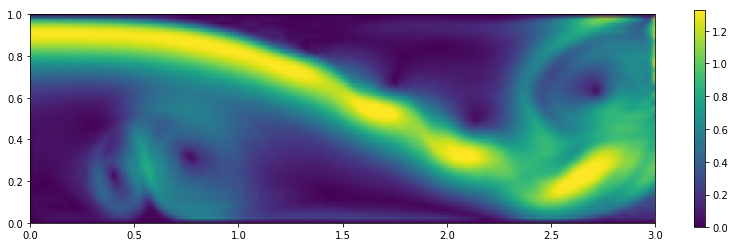

In [11]:
from IPython.display import HTML

figsize(14, 4)
fields = [vel_norm(uu) for uu in solutions]
HTML(vis.animate_field(fields, geo, res=(50, 150)).to_html5_video())

In [12]:
xgrid = linspace(0, 1, 30)
xygrid = (xgrid, xgrid)

U, pre = get_components(u)
velocity = geometry.BSplineFunc(kvs_u, U)
pressure = geometry.BSplineFunc(kvs_p, pre)

G = geo.grid_eval(xygrid)
vel = velocity.grid_eval(xygrid)
pre = pressure.grid_eval(xygrid)

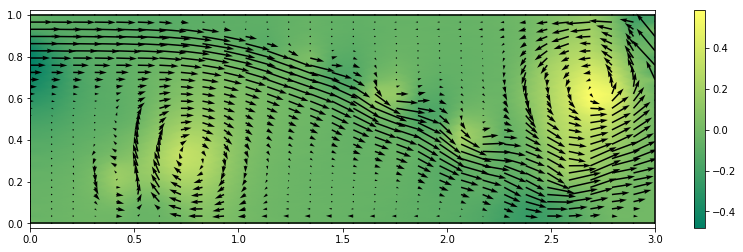

In [13]:
figsize(14, 4)

vis.plot_geo(geo, grid=2)
pcolormesh(G[...,0], G[...,1], pre, cmap='summer', shading='gouraud');
colorbar()
quiver(G[...,0], G[...,1], vel[...,0], vel[...,1]);
axis('equal');